In [2]:
%matplotlib inline
import math
import time 
import numpy as np
import torch
from d2l import torch as d2l

In [3]:
#矢量化代码的速度优势
n = 10000
a = torch.ones([n])
b = torch.ones([n])


In [4]:
class Timer:
    def __init__(self):
        self.times=[]
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times)/len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cunsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f}sec')

0.10312sec


In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

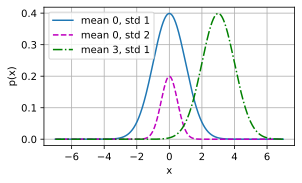

In [7]:
def normal(x,mu,sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5*sigma**2*(x-mu)**2)

x = np.arange(-7,7,0.01)
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
    ylabel='p(x)', figsize=(4.5, 2.5),
    legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 线性回归

In [9]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [10]:
def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

In [11]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([ 0.3427, -0.1775]) 
label: tensor([5.4848])


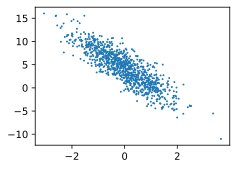

In [12]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1);

In [13]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [14]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3426,  1.1789],
        [ 1.2275, -1.1999],
        [-0.2751, -0.2951],
        [ 1.1036, -0.0234],
        [-0.8083,  0.0901],
        [ 2.5404,  1.1508],
        [ 0.5760,  0.5063],
        [ 0.8633,  0.7580],
        [ 0.1337, -1.1369],
        [ 0.3645, -1.3267]]) 
 tensor([[ 0.8756],
        [10.7265],
        [ 4.6483],
        [ 6.4975],
        [ 2.2732],
        [ 5.3646],
        [ 3.6343],
        [ 3.3580],
        [ 8.3352],
        [ 9.4328]])


In [15]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [16]:
features1 = torch.randn((3,2))

In [17]:
a = list(range(len(features1)))
a

[0, 1, 2]

In [18]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

In [19]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [20]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

In [21]:
#开始训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.036213
epoch2,loss0.000134
epoch3,loss0.000050


In [22]:
#简洁写法
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [23]:
 true_w = torch.tensor([2,-3.4])
 true_b = 4.2
 features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [24]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [25]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [26]:
from torch import nn

In [27]:
net = nn.Sequential(nn.Linear(2,1))

In [28]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [29]:
loss = nn.MSELoss()

In [30]:
trainer = torch.optim.SGD(net.parameters(),lr = 0.03)

In [31]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch:{epoch+1},loss{l:f}')

epoch:1,loss0.000205
epoch:2,loss0.000102
epoch:3,loss0.000102


In [32]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [33]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root = '../data', train = True, transform = trans,download = True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root = '../data', train = False,transform = trans,download = True
)

In [34]:
len(mnist_train),len(mnist_test)

(60000, 10000)

In [35]:
print(mnist_train)
#mnist_train[0]是一个元组（images，target）
mnist_train[1][0].shape

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([1, 28, 28])

In [36]:
def get_fashion_mnist_labels(labels): #@save
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [37]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
             # 图片张量
            ax.imshow(img.numpy())
        else:
             # PIL图片
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            if titles: 
                ax.set_title(titles[i])
            return axes

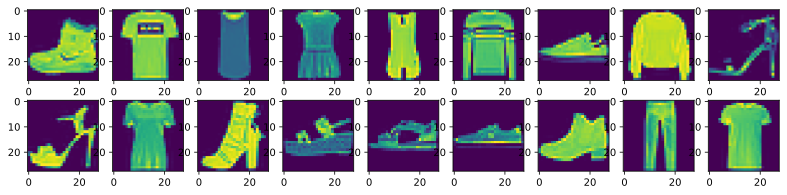

In [38]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [39]:
batch_size = 256
def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train,batch_size,shuffle = True,num_workers = get_dataloader_workers())

In [40]:
timer = d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop():.2f} sec'    

'2.84 sec'

In [41]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
     trans = [transforms.ToTensor()]
     if resize:
         trans.insert(0, transforms.Resize(resize))
         trans = transforms.Compose(trans)
         mnist_train = torchvision.datasets.FashionMNIST(
         root="../data", train=True, transform=trans, download=True)
         mnist_test = torchvision.datasets.FashionMNIST(
         root="../data", train=False, transform=trans, download=True)
     return (data.DataLoader(mnist_train, batch_size, shuffle=True,
             num_workers=get_dataloader_workers()),
             data.DataLoader(mnist_test, batch_size, shuffle=False,
             num_workers=get_dataloader_workers()))

In [42]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
     print(X.shape, X.dtype, y.shape, y.dtype)
     break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [43]:
#softmax回归从零开始实现
import torch
from IPython import display
from d2l import torch as d2l

In [44]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [45]:
import torch
from IPython import display
from d2l import torch as d2l

In [46]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [47]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad =True)
b = torch.zeros(num_outputs, requires_grad = True)

In [48]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True).shape, X.sum(1, keepdim=True).shape


(torch.Size([1, 3]), torch.Size([2, 1]))

In [49]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim = True)
    return X_exp / partition

In [50]:
X = torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0653, 0.1426, 0.4585, 0.2983, 0.0353],
         [0.4221, 0.0450, 0.2459, 0.1799, 0.1071]]),
 tensor([1.0000, 1.0000]))

In [51]:
X_exp1 = torch.exp(X)
X_exp1

tensor([[0.8203, 1.7921, 5.7607, 3.7479, 0.4441],
        [2.3830, 0.2539, 1.3882, 1.0159, 0.6046]])

In [52]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [53]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y] #y_hat[0,1] and y_hat[1][2]

tensor([0.1000, 0.5000])

In [54]:
def cross_entropy(y_hat, y):
    return- torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [55]:
len(y_hat)

2

In [56]:
# 判断结果正确率
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    print(cmp)
    print(cmp.shape)
    return float(cmp.type(y.dtype).sum())
accuracy(y_hat,y)/len(y)

tensor([False,  True])
torch.Size([2])


0.5

In [57]:
print(y)
y_hat.argmax(axis = 1).type(y.dtype)

tensor([0, 2])


tensor([2, 2])

In [58]:
class Accumulator: #@save
     def __init__(self, n):
         self.data = [0.0] * n
     def add(self, *args):
         self.data = [a + float(b) for a, b in zip(self.data, args)]
     def reset(self):
         self.data = [0.0] * len(self.data)
     def __getitem__(self, idx):
         return self.data[idx]

In [59]:
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [60]:
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [61]:
class Animator: #@save
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [62]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [63]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

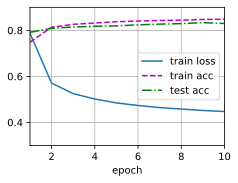

In [64]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

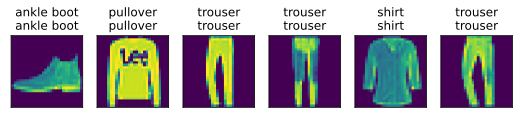

In [65]:
def predict_ch3(net, test_iter, n=6): #@save
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)

In [66]:
import torch
from torch import nn
from d2l import torch as d2l

In [67]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

In [68]:
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std = 0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [69]:
loss = nn.CrossEntropyLoss(reduction = 'none')

In [70]:
trainer = torch.optim.SGD(net.parameters(),lr = 0.1)

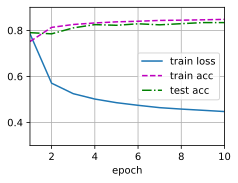

In [71]:
num_eposhs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)